In [17]:
using Printf
using Interpolations
using PyPlot
using Optim
using Roots
using LinearAlgebra
using QuantEcon
using PCHIPInterpolation
using BenchmarkTools
using Distributions
using XLSX
using DelimitedFiles
using Dierckx #https://github.com/kbarbary/Dierckx.jl
using Distributed
using DataFrames
using PooledArrays
using CSV

include("KS_markov.jl");
include("KS_household.jl");
include("KS_simulation.jl");
include("KS_OLS.jl")

KS_R2 (generic function with 1 method)

# Main Loop

In [15]:
# main roop
m = Construct()
println("=== Krusell & Smith (1998) ===")
println("[num, a0, a1, b0, b1, diff_params]")
flush(stdout)


# (0) preparation
diff_params = 1.0
tol_params = 1e-7
num_params = 1
maxit_params = 50001
lambda = 0.8

v0 = ones(m.Nk, m.Ne, m.Nz, m.Nm)

z_sim_index, z_sim = markov_sim(m)
mu0 = ones(m.Nk_dist, m.Ne) ./ (m.Nk_dist*m.Ne)

a0, a1, b0, b1 = 0.095, 0.962, 0.085, 0.965

@time while (diff_params > tol_params) & (num_params < maxit_params)

    # (1) VFI
    v, g, c = KS_vfi(m,a0,a1,b0,b1,v0);

    # (2) Simulation
    #mu_sim0 = KS_stationary(g,m,mu0)
    #kbar_sim = sim_kbar(m,g,z_sim_index,mu_sim0);
    kbar_sim = sim_kbar(m,g,z_sim_index,mu0);
    
    # (3) Estimation
    a0_hat, a1_hat, b0_hat, b1_hat  = KS_OLS(m, kbar_sim, z_sim_index)

    # (4) update
    diff_params = max.(abs(a0-a0_hat), abs(a1-a1_hat), abs(b0-b0_hat), abs(b1-b1_hat))
    
    a0_new = lambda*a0 + (1-lambda)*a0_hat
    a1_new = lambda*a1 + (1-lambda)*a1_hat
    b0_new = lambda*b0 + (1-lambda)*b0_hat
    b1_new = lambda*b1 + (1-lambda)*b1_hat

    println([num_params, a0, a1, b0, b1, diff_params])
    flush(stdout)
    
    num_params += 1
    a0, a1, b0, b1 = copy(a0_new), copy(a1_new), copy(b0_new), copy(b1_new)
    v0 = copy(v)

end

=== Krusell & Smith (1998) ===
[num, a0, a1, b0, b1, diff_params]
[1.0, 0.095, 0.962, 0.085, 0.965, 0.0019102403122306377]
[2.0, 0.09529893041356148, 0.9618772938774982, 0.08531948926694859, 0.9646179519375538, 0.002163149435228301]
[3.0, 0.09486630052651582, 0.962112487952987, 0.08502410997309787, 0.9646033791735962, 0.002494525807707426]
[4.0, 0.09436739536497434, 0.9623801751061714, 0.0846235099561009, 0.9646815128902698, 0.001972988683662455]
[5.0, 0.09397279762824184, 0.9625960112229832, 0.0843079953602811, 0.9647495910554227, 0.0014291662281537554]
[6.0, 0.0936869643826111, 0.9627564874756858, 0.08409289775755299, 0.9647918937833004, 0.0010090257128748392]
[7.0, 0.09348515924003611, 0.9628731455408879, 0.08395535855441506, 0.9648132433051073, 0.0007095553411985422]
[8.0, 0.0933432481717964, 0.9629577092585637, 0.08387110657519631, 0.964820829994635, 0.0005011265978887708]
[9.0, 0.09324302285221864, 0.963019264993042, 0.08382174221634613, 0.9648202740547513, 0.0003567639817239343]

# Check Accuracy

In [22]:
# 収束した{a0,a1,b0,b1} で計算する

# (1) VFI
v, g, c = KS_vfi(m,a0,a1,b0,b1,v0);
# (2) Simulation
kbar_sim = sim_kbar(m,g,z_sim_index,mu0);
# (3) Estimation
a0_hat, a1_hat, b0_hat, b1_hat  = KS_OLS(m, kbar_sim, z_sim_index);
# (4) R2_bad
R2_good, R2_bad, sig2_good, sig2_bad = KS_R2(m,kbar_sim,z_sim_index,a0_hat,a1_hat,b0_hat,b1_hat);
sig_good, sig_bad = sig2_good^(0.5)*100, sig2_bad^(0.5)*100

println("R^2 in good state is $R2_good")
println("R^2 in bad state is $R2_bad")

println("sigma in good state is $sig_good%")
println("sigma in bad state is $sig_bad%")

R^2 in good state is 0.9999980263285504
R^2 in bad state is 0.9999970337662493
sigma in good state is 0.003080822988836201%
sigma in bad state is 0.0036578504312578435%


# den Haan Test

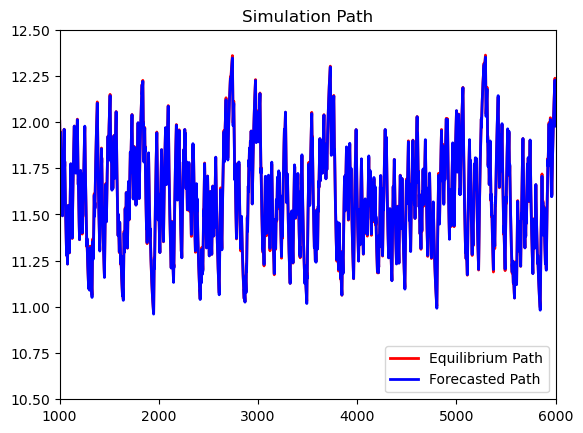

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [61]:
# forecasted value
kbar_forecast = zeros(m.T_sim - m.T0)
kbar_forecast[1] = kbar_sim[1]

for t in 1:(m.T_sim - m.T0 - 1)
    if z_sim_index[Int(m.T0+t)] == 1.0 # bad state
        kbar_forecast[t+1] = exp(b0_hat + b1_hat * log(kbar_forecast[t]))
    else
        kbar_forecast[t+1] = exp(a0_hat + a1_hat * log(kbar_forecast[t]))
    end
end

fig, ax = plt.subplots()
ax.plot(m.T0+1:m.T_sim, kbar_sim, label="Equilibrium Path", c="r", lw=2)
ax.plot(m.T0+1:m.T_sim, kbar_forecast, label="Forecasted Path", c="b",lw=2)
ax.set(xlim=(m.T0,m.T_sim), ylim=(10.5,12.5), title="Simulation Path")
ax.legend(loc="lower right")
plt.show()
#plt.savefig("den_haan_test.png")

In [48]:
errors = abs.((kbar_sim .- kbar_forecast) ./ kbar_forecast);
mean_error = mean(errors*100)
max_error = maximum(errors*100)

println("mean error: $mean_error %")
println("maximum error: $max_error %")

mean error: 0.04183481959390048 %
maximum error: 0.16264928961015226 %
